In [119]:
import numpy as np

# pdf used to evaluate at x_n
def gaussian_pdf_1d(x, mu, var):
    return (1.0 / np.sqrt(2 * np.pi * var)) * np.exp(-(x - mu) ** 2 / (2 * var))

# equation 9.23 in the book
def calculate_responsibilites(data, pi, mu, sigma):
    if data.ndim == 1: data = data[:, None]
    N = data.shape[0]

    responsibilities = np.zeros((N, len(pi)))
    for n in range(N):
        for k in range(K):
            responsibilities[n, k] = pi[k] * gaussian_pdf_1d(data[n, 0], mu[k], sigma[k])

    return responsibilities / np.sum(responsibilities, axis=1, keepdims=True)

# equation 9.28 in the book
def log_likelihood(data, pi, mu, sigma):
    if data.ndim == 1: data = data[:, None]
    N = data.shape[0]

    total_sum = 0
    for n in range(N):
        inner_sum = 0
        for k in range(K):
            inner_sum += pi[k] * gaussian_pdf_1d(data[n], mu[k], sigma[k])

        total_sum += np.log(inner_sum)

    return total_sum

In [141]:
def run_em(data, K, max_iters, threshold=0.2):
    if data.ndim == 1: data = data[:, None]
    N, D = data.shape

    pi = np.ones(K) / K # uniform distribution initilization
    mu = np.random.uniform(data.min(), data.max(), size=K) # randomly initialize means within data range
    sigma = np.full(K, data.var()) # initialize all vars to total data variance

    # print(pi)
    # print(means)
    # print(covars)

    responsibilities = calculate_responsibilites(data, pi, mu, sigma)
    ll_old = log_likelihood(data, pi, mu, sigma)

    # save copies of results in as tuples in a list
    results = [(pi.copy(), mu.copy(), sigma.copy())]

    for i in range(1, max_iters):
        gamma = calculate_responsibilites(data, pi, mu, sigma)

        N_k = np.sum(gamma, axis=0)

        # calculate new values for pi, mu, and sigma
        pi = N_k / N
        mu = (gamma.T @ data[:, 0]) / N_k

        sigma_new = np.zeros(sigma.shape)
        for k in range(K):
            sigma_total = 0.0
            for n in range(N):
                sigma_total += gamma[n, k] * (data[n, 0] - mu[k]) * (data[n, 0] - mu[k]).T
            sigma[k] = sigma_total / N_k[k]

        # recalculate log likelihood
        ll = log_likelihood(data, pi, mu, sigma)

        # save results
        results.append((pi.copy(), mu.copy(), sigma.copy()))

        # threshold test using L1
        if np.abs(ll - ll_old) < threshold:
            print(f"converged at {i}th iteration")
            break

        ll_old = ll

    return results


converged at 45th iteration


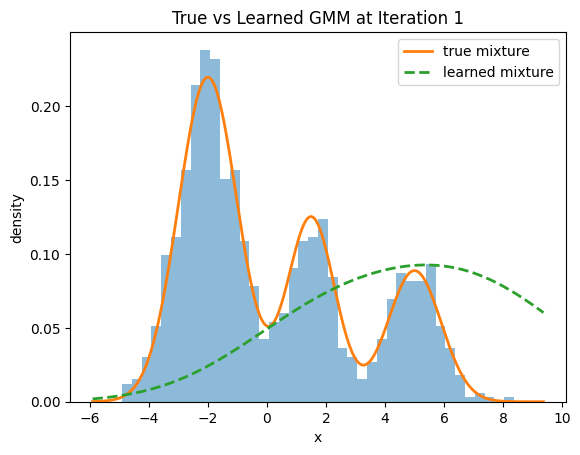

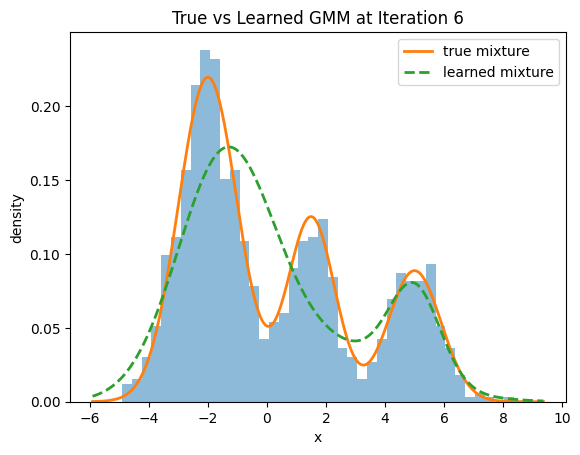

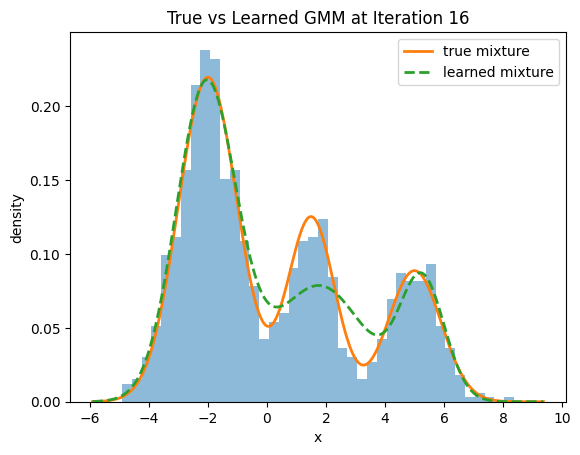

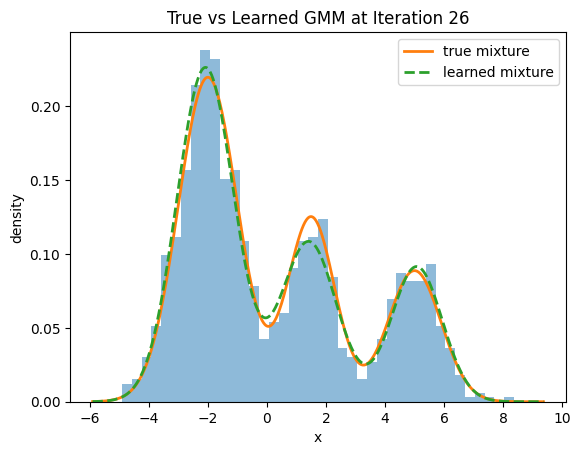

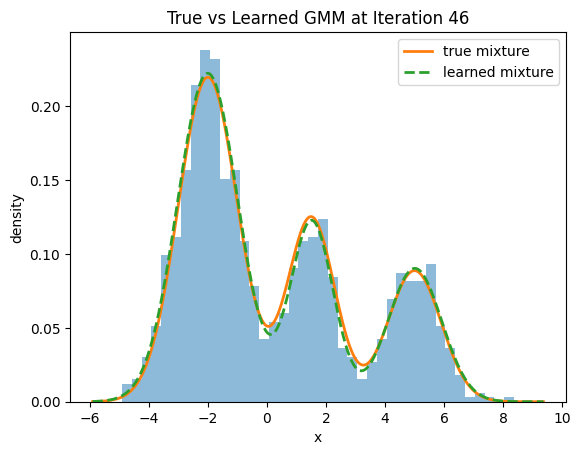

In [144]:
import numpy as np
import matplotlib.pyplot as plt

K = 3 # num gaussians in the mixture
N = 1000 # number of samples

np.random.seed(7)

true_pi = np.array([0.55, 0.25, 0.20]) # must sum to 1
true_mu = np.array([-2.0, 1.5, 5.0])
true_sigma = np.array([1**2, 0.8**2, 0.9**2])

# N random choices for z using true probs
z = np.random.choice(K, size=N, p=true_pi)

# randomly generate data
data = np.array([np.random.normal(true_mu[k], np.sqrt(true_sigma[k])) for k in z])

# run em algorithm, set threshold here
results = run_em(data=data, K=K, max_iters=1000, threshold=0.001)

# plot a couple indices
indices_to_plot = [0, 5, 15, 25, -1]
for idx in indices_to_plot:
    pi, mu, sigma = results[idx]
    x = np.linspace(data.min()-1, data.max()+1, 600)

    true_mix = np.zeros_like(x)
    for k in range(K):
        true_mix += true_pi[k] * gaussian_pdf_1d(x, true_mu[k], true_sigma[k])

    learned_mix = np.zeros_like(x)
    for k in range(len(pi)):
        learned_mix += pi[k] * gaussian_pdf_1d(x, mu[k], sigma[k])

    plt.hist(data, bins=40, density=True, alpha=0.5)
    plt.plot(x, true_mix, label="true mixture", lw=2)
    plt.plot(x, learned_mix, label="learned mixture", lw=2, linestyle="--")
    plt.legend()
    plt.xlabel("x"); plt.ylabel("density")
    plt.title(f"True vs Learned GMM at Iteration {idx + 1 if idx + 1 > 0 else len(results)}")
    plt.show()